# Emisiones globales


In [1]:
from pathlib import Path

import csv
import time
import re

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns


%matplotlib inline

## Configuración
 
El dataset  https://www.kaggle.com/datasets/ashishraut64/global-methane-emissions



In [2]:
data_folder = Path().cwd().parent / 'data'

work_folder =  data_folder / 'global_emissions' 

csv_file = work_folder / 'Methane_final.csv'

## Carga de datos

El csv contiene el indice asi que usamos `index_col` para no incluirlo.

In [3]:
df = pd.read_csv(csv_file, index_col=[0])

print(f'Filas: {df.shape[0]:,} columnas: {df.shape[1]}')

Filas: 1,548 columnas: 8


## Funciones

In [4]:
def print_memory(dfm):
    memory_usage = dfm.memory_usage(deep=True)
    print("--- Memory consumption ---")
    print(memory_usage, end="\n\n")
    print(f'{memory_usage.sum()/1024/1024:,.2f} MB')

## EDA

### Descripcion de los datos

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1548 entries, 0 to 1547
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   region     1548 non-null   object 
 1   country    1548 non-null   object 
 2   emissions  1548 non-null   float64
 3   type       1548 non-null   object 
 4   segment    1548 non-null   object 
 5   reason     1548 non-null   object 
 6   baseYear   1548 non-null   object 
 7   notes      1548 non-null   object 
dtypes: float64(1), object(7)
memory usage: 108.8+ KB


In [6]:
print_memory(df)

--- Memory consumption ---
Index         12384
region       104900
country      101751
emissions     12384
type          97839
segment      108362
reason        95970
baseYear      96003
notes        585077
dtype: int64

1.16 MB


### Renombrando las columnas

Acostumbro usar columnas en snake case. La razon para eliminar los espacios es q se puede utilizar la notacion con punto. Por ejempl0 `df.guest_satisfaction`


In [7]:
col_renaming_dict = {}
for col in df.columns:
    val = col.lower().replace(" ", "_").replace('(', '').replace(')', '')
    col_renaming_dict[col] = val
    # print(f'{col}: {val}')
    
df.rename(columns=col_renaming_dict, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1548 entries, 0 to 1547
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   region     1548 non-null   object 
 1   country    1548 non-null   object 
 2   emissions  1548 non-null   float64
 3   type       1548 non-null   object 
 4   segment    1548 non-null   object 
 5   reason     1548 non-null   object 
 6   baseyear   1548 non-null   object 
 7   notes      1548 non-null   object 
dtypes: float64(1), object(7)
memory usage: 108.8+ KB


### Tamano del dataframe


In [8]:
memory_usage = df.memory_usage(deep=True)
print("--- Memory consumption ---")
print(memory_usage, end="\n\n")
print(f'{memory_usage.sum()/1024/1024:,.2f} MB')

--- Memory consumption ---
Index         12384
region       104900
country      101751
emissions     12384
type          97839
segment      108362
reason        95970
baseyear      96003
notes        585077
dtype: int64

1.16 MB


In [9]:
df.describe()

,emissions
count,1548.000000
mean,643.255972
std,5566.238201
min,0.000459
25%,2.659361
50%,24.064669
75%,128.419594
max,141953.765625


In [10]:
df.head()

,region,country,emissions,type,segment,reason,baseyear,notes
0,Africa,Algeria,257.611206,Agriculture,Total,All,2019-2021,Average based on United Nations Framework Conv...
1,Africa,Algeria,0.052000,Energy,Bioenergy,All,2022,Estimates from end-uses are for 2020 or 2021 (...
2,Africa,Algeria,130.798996,Energy,Gas pipelines and LNG facilities,Fugitive,2022,Not available
3,Africa,Algeria,69.741898,Energy,Gas pipelines and LNG facilities,Vented,2022,Not available
4,Africa,Algeria,213.987000,Energy,Onshore gas,Fugitive,2022,Not available


### Categorias

#### Explorando categorias

In [11]:
df['region'].value_counts()

Africa                       406
Europe                       302
Asia Pacific                 270
Middle East                  187
Central and South America    183
Russia & Caspian              96
North America                 61
World                         22
Other                         21
Name: region, dtype: int64

In [12]:
df['country'].value_counts()

World                       22
Iran                        22
European Union              22
Russia                      22
Kazakhstan                  22
                            ..
Central African Republic     3
Liberia                      3
Sierra Leone                 3
Seychelles                   3
Gambia                       3
Name: country, Length: 105, dtype: int64

In [13]:
df['type'].value_counts()

Energy         1233
Agriculture     105
Other           105
Waste           105
Name: type, dtype: int64

In [14]:
df['segment'].value_counts()

Total                                             414
Onshore oil                                       217
Gas pipelines and LNG facilities                  164
Offshore oil                                      159
Onshore gas                                       144
Offshore gas                                      118
Other from oil and gas                             98
Bioenergy                                          93
Other from coal                                    66
Steam coal                                         30
Coking coal                                        24
Satellite-detected large oil and gas emissions     21
Name: segment, dtype: int64

In [15]:
df['baseyear'].value_counts()

2022         1233
2019-2021     315
Name: baseyear, dtype: int64

#### Convirtiendo columnas en datos categoricos

In [16]:
categorical_columns =['region', 'country', 'type', 'segment']
for cat in categorical_columns:
    df[cat] = df[cat].astype('category')

In [17]:
print_memory(df)

--- Memory consumption ---
Index         12384
region         2460
country       12608
emissions     12384
type           1975
segment        2728
reason        95970
baseyear      96003
notes        585077
dtype: int64

0.78 MB


### Descripcion de los datos numericos

In [18]:
df.describe()

,emissions
count,1548.000000
mean,643.255972
std,5566.238201
min,0.000459
25%,2.659361
50%,24.064669
75%,128.419594
max,141953.765625


#### Box plots

<Axes: >

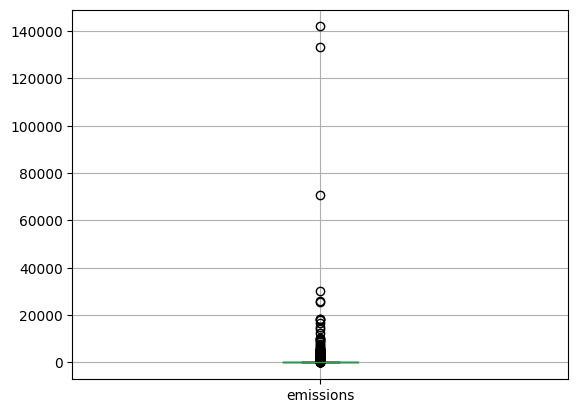

In [19]:
df.boxplot(column='emissions')

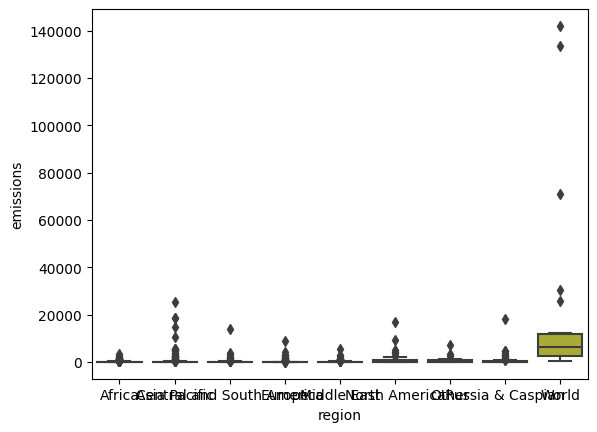

In [20]:
sns.boxplot(x="region", y="emissions", data=df)

plt.show()

### Matriz de Correlación

In [21]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')


/tmp/ipykernel_475952/2331704588.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


,emissions
emissions,1.000000


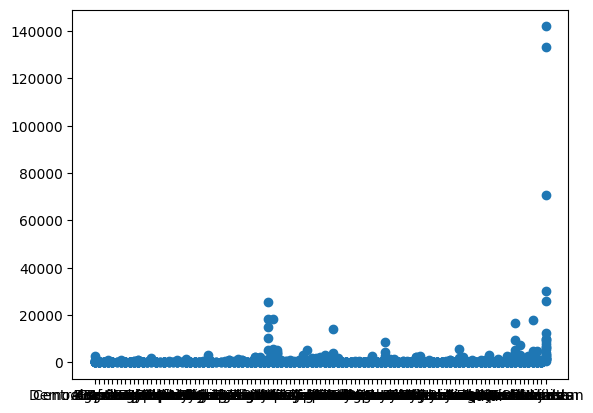

In [22]:
plt.scatter(df['country'], df['emissions'])

### Histrogramas

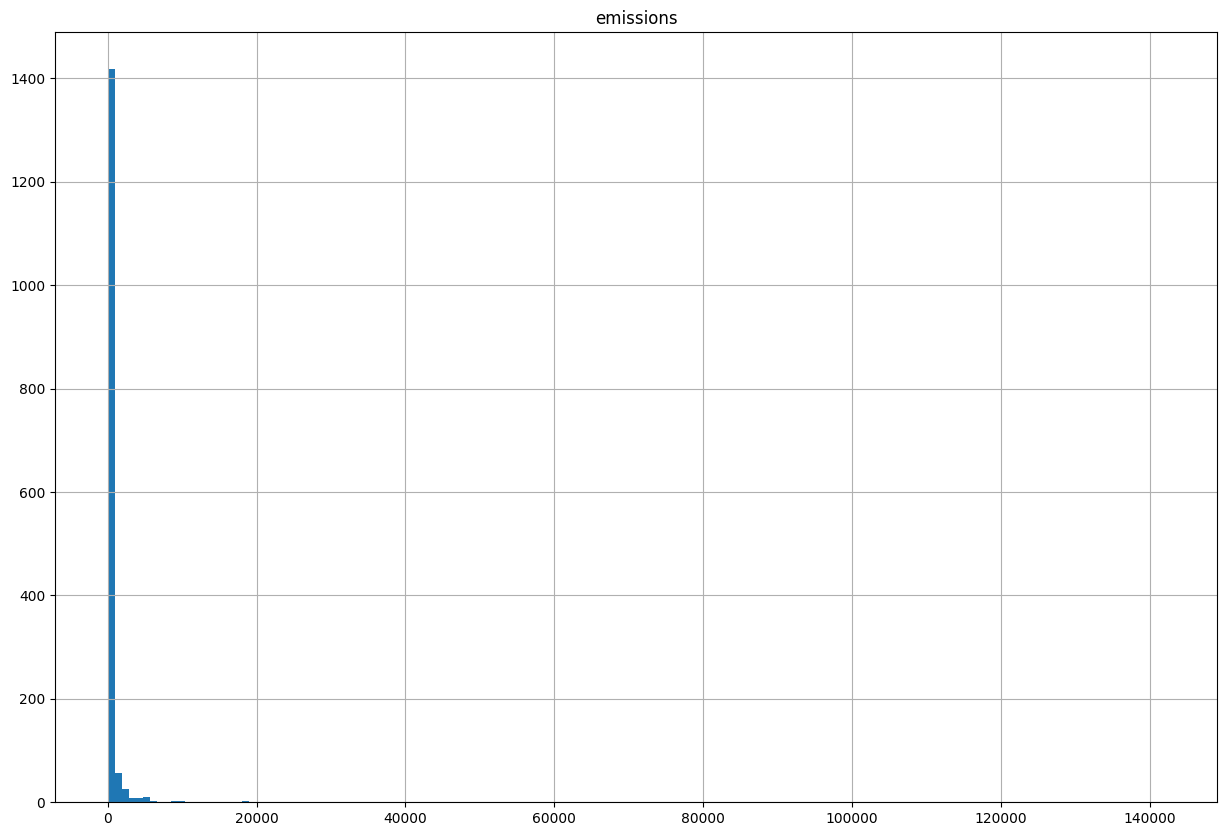

In [23]:
df.hist(bins=150, figsize=(15, 10))
plt.show()

## Guardando el dataframe


In [29]:
parquet_file = data_folder / f'{csv_file.stem}.parquet'
df.to_parquet(parquet_file)

print(parquet_file.stat().st_size)



35970


In [30]:
dfp = pd.read_parquet(parquet_file)

dfp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1548 entries, 0 to 1547
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   region     1548 non-null   category
 1   country    1548 non-null   category
 2   emissions  1548 non-null   float64 
 3   type       1548 non-null   category
 4   segment    1548 non-null   category
 5   reason     1548 non-null   object  
 6   baseyear   1548 non-null   object  
 7   notes      1548 non-null   object  
dtypes: category(4), float64(1), object(3)
memory usage: 72.4+ KB
